In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import matplotlib.colors as mcolors
from iminuit import Minuit, cost
from iminuit.cost import LeastSquares
from scipy.ndimage import convolve
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [858]:
BeamE = []
ECalYield = [[],[],[]]
ECalYieldErr = [[],[],[]]
ECalRes = [[],[],[]]
ECalResErr = [[],[],[]]
deg = [4, 15, 28]

In [1021]:
energy = 10

energy = energy + 0.2077120822622108

lowRange = 0
highRange = 3000
bins = highRange - lowRange
lowFit = 0
highFit = 3000

input_file_name = 'Data/WScFi10GeV28degrees.pkl'

with open(input_file_name, 'rb') as file:
    dataframes_dict = pickle.load(file)
    
calibration_file_name = 'Data/28deg_cali.pkl'

with open(calibration_file_name, 'rb') as file:
    calibrations_dict = pickle.load(file)
towers = np.array(calibrations_dict['towers'])
tower_calibrations = np.array(calibrations_dict['tower_calibrations'])
x_map = np.array(calibrations_dict['x_map'])
y_map = np.array(calibrations_dict['y_map'])
calibration_map = np.array(calibrations_dict['calibration_map'])


Text(0, 1, 'Y [mm]')

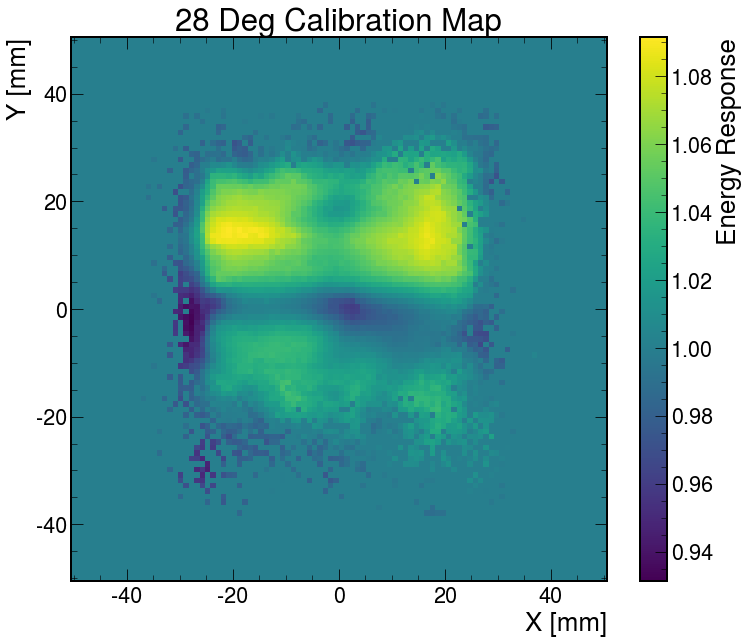

In [1022]:
fig, axs = plt.subplots(1, 1, figsize=(12, 10))
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

plt.pcolormesh(x_map, y_map, calibration_map)
plt.colorbar(label="Energy Response")
plt.title("28 Deg Calibration Map")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")

In [1023]:
def least_squares_loss(A, mu, sigma):
    y = gauss(bins, A, mu, sigma)
    return np.sum((data - y)**2)

def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))


def channel_to_xy(channel):
    # Validate the channel number
    if not (0 <= channel <= 15):
        raise ValueError("Channel number must be between 0 and 15.")
        
    tower_size = 25
    
    col = channel % 4
    row = channel // 4

    origin_offset = 2 * tower_size

    x = (col * tower_size + tower_size / 2) - origin_offset
    y = (row * tower_size + tower_size / 2) - origin_offset
    
    return (x, y)

def find_closest_value(x_grid, y_grid, z_smooth, x_pos, y_pos):
    # Calculate the distance between the input point and all points in the grid
    distances = np.sqrt((x_grid - x_pos)**2 + (y_grid - y_pos)**2)
    
    # Find the indices of the minimum distance
    min_index = np.unravel_index(np.argmin(distances), distances.shape)
    
    # Return the value at the closest point in z_smooth
    return z_smooth[min_index]

def resolution(x, A, b):
    return (A/np.sqrt(x)) + b

def lin(x, A, b):
    return (A*x) + b

In [1024]:
hod_df = dataframes_dict['hod_df']
rawElec = [[] for i in range(16)]

# Select ADC values for all channels
adc_values = hod_df[[f'ch_{i + 48}' for i in range(16)]].values

# Calculate y multiplicity
ymult = np.sum(adc_values[:, :8] > 0, axis=1)

# Calculate x multiplicity
xmult = np.sum(adc_values[:, 8:] > 0, axis=1)

Sc1RawADCSpectrum = dataframes_dict['sc1_df']['ch_32']
Ce1RawADCSpectrum = dataframes_dict['ce1_df']['ch_35']
Ce2RawADCSpectrum = dataframes_dict['ce2_df']['ch_37']

# Initialize arrays
ElectronEcalCh = np.zeros((16, len(hod_df['ch_48'])))
ecutMask = np.zeros(len(hod_df['ch_48']), dtype=bool)

# Calculate the ecut array
ecut = (Sc1RawADCSpectrum < 1000) & (xmult == 1) & (ymult == 1) & (Ce1RawADCSpectrum > 0) & (Ce1RawADCSpectrum < 300) & (Ce2RawADCSpectrum == 0)

# Create a calibration array
calibration = np.ones(16)
for i in range(16):
    if len(towers[towers == i]) != 0:
        calibration[i] = tower_calibrations[np.argwhere(towers == i)[0]]

# Normalize the dataframes_dict values by calibration
for i in range(16):
    ElectronEcalCh[i] = dataframes_dict['ecal_df'][f'ch_{i+16}'] / calibration[i]
    rawElec[i] = dataframes_dict['ecal_df'][f'ch_{i+16}']
# Calculate ECalSum for all events
ECalSum = np.sum(ElectronEcalCh, axis=0)

# Indices to check
indices_to_check = [5, 6, 9, 10]

# Step 1: Find the maximum value in each sublist
max_values = np.max(ElectronEcalCh, axis=0)

# Step 2: Extract values at the specified indices
values_at_indices = ElectronEcalCh[indices_to_check]

# Step 3: Check if the max values are in the extracted values
is_max_at_indices = np.any(values_at_indices == max_values, axis=0)

# Calculate ECalMultiplicity for all events
ECalMultiplicity = np.sum(np.array(rawElec) > 10, axis=0)

# Update ecutMask
ecutMask = ecut & (ECalMultiplicity >= 3)

# Filter ECalSumElectron and ElectronEcalCh based on ecutMask
ECalSumElectron = ECalSum[ecutMask]
ElectronEcalCh = ElectronEcalCh[:, ecutMask]

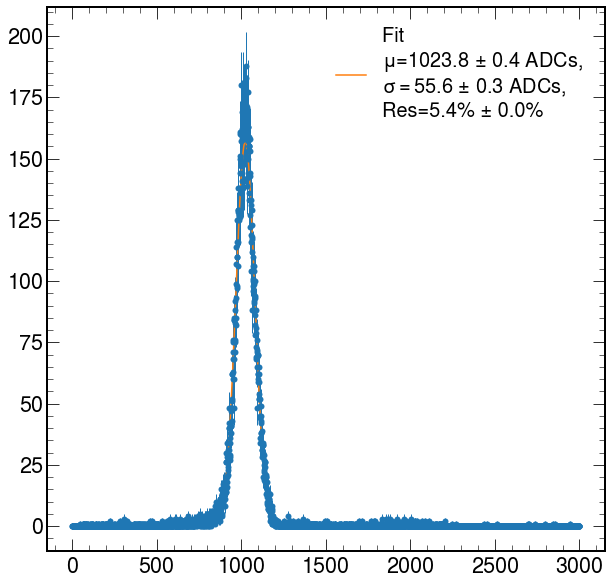

In [1025]:
h, bins = np.histogram(ECalSumElectron, bins=bins, range=(lowRange,highRange))
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(h)
plt.errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue',
                      capsize=0, elinewidth=1, markeredgewidth=0)

mask = (h > 0) & (bin_centers > lowFit) & (bin_centers < highFit)
initial_params = [max(h[mask]),np.mean(ECalSumElectron[ECalSumElectron > lowFit]),np.std(ECalSumElectron[ECalSumElectron > lowFit])]

m = Minuit(LeastSquares(bin_centers[mask], h[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
m.limits["sigma"] = (0, None)
m.migrad()
fitted_params = m.values
errors = m.errors
A_fit = fitted_params['A']
mu_fit = fitted_params['mu']
sigma_fit = fitted_params['sigma']
A_err = errors['A']
mu_err = errors['mu']
sigma_err = errors['sigma']

x = np.linspace(lowFit, highFit, 2000)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
res = sigma_fit/mu_fit
res = np.sqrt((100*res)**2 - 1.8**2)

# Step 1: Calculate r and its error
r = sigma_fit / mu_fit
delta_r = r * np.sqrt((sigma_err / sigma_fit)**2 + (mu_err / mu_fit)**2)

# Step 2: Calculate s and its error
s = 100 * r
delta_s = 100 * delta_r

# Step 3: Calculate res and its error
res = np.sqrt(s**2 - 1.8**2)
delta_res = (s / np.sqrt(s**2 - 1.8**2)) * delta_s

x = np.linspace(lowFit, highFit, 1500)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
res = 100 * sigma_fit/mu_fit

plt.plot(x, y_fit, 'tab:orange', label='Fit \n$\mu$=%2.1f ± %2.1f ADCs, \n$\sigma=$%2.1f ± %2.1f ADCs, \nRes=%2.1f%% ± %2.1f%%'%(mu_fit, mu_err, sigma_fit, sigma_err, res, delta_res))
plt.legend(loc='upper right', fontsize=20)   

ElectronECut = (ECalSumElectron < ( mu_fit + (3* sigma_fit))) & (ECalSumElectron > ( mu_fit - (3* sigma_fit)))


MeanElectron = mu_fit


In [1026]:
ElectronEcalCh = ElectronEcalCh[:, ElectronECut]
ECalSumElectron = ECalSumElectron[ElectronECut]

In [1027]:

# Calculate weights
log_values = np.log(ElectronEcalCh / ECalSumElectron)

w = np.maximum(log_values + 3.8, 0)

# Calculate weighted positions
xy_coords = np.array([channel_to_xy(ch) for ch in range(16)])  # Precompute xy coordinates

# Weighted sums
weighted_x = (xy_coords[:, 0].reshape(16, 1) * w).sum(axis=0)
weighted_y = (xy_coords[:, 1].reshape(16, 1) * w).sum(axis=0)

# Total weights
w_tot = w.sum(axis=0)

# Calculate final positions
calix_reco = weighted_x / w_tot
caliy_reco = weighted_y / w_tot

# Convert to numpy arrays
calix_reco = np.array(calix_reco)
caliy_reco = np.array(caliy_reco)

/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [1028]:
map_caliEvtSum = []
for evt in range(len(ECalSumElectron)):
    cali = find_closest_value(x_map, y_map, calibration_map, calix_reco[evt], caliy_reco[evt])
    map_caliEvtSum.append(ECalSumElectron[evt] / cali)
        
map_caliEvtSum = np.array(map_caliEvtSum)

Text(0, 1, 'Reco Y [mm]')

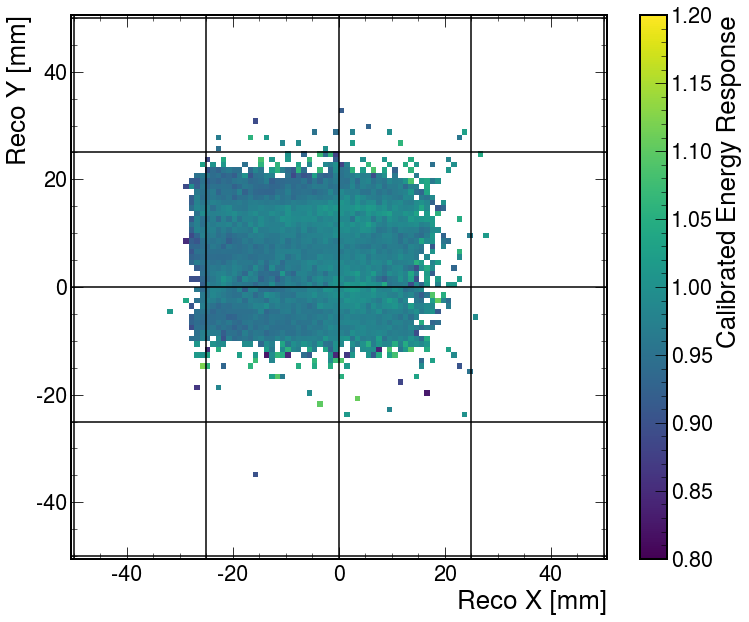

In [1029]:
square_size = 25
grid_size = 4 * square_size

fig, axs = plt.subplots(1, 1, figsize=(12, 10))
y, x = np.meshgrid(np.linspace(-50, 50, 100), np.linspace(-50, 50, 100))
z = [[] for i in range(len(x))] 
zr = [[] for i in range(len(x))] 
width = 0.5
for i, pos in enumerate(x):
    for j, x_pos in enumerate(pos):
        y_pos = y[i][j]
        mask = (calix_reco > (x_pos - width)) & (calix_reco < (x_pos + width)) & (caliy_reco > (y_pos - width)) & (caliy_reco < (y_pos + width))
        zr[i].append(np.mean(map_caliEvtSum[mask]) / MeanElectron)
        z[i].append(np.mean(map_caliEvtSum[mask]))
        


plt.pcolormesh(x, y, zr, vmin = 0.8, vmax = 1.2)


for xi in range(0, grid_size + 1, square_size):
    plt.axvline(x=xi - grid_size / 2, color='black')

for yi in range(0, grid_size + 1, square_size):
    plt.axhline(y=yi - grid_size / 2, color='black')
    
plt.colorbar(label="Calibrated Energy Response")

plt.xlabel("Reco X [mm]")
plt.ylabel("Reco Y [mm]")

Mean: 992.1518952360819
Mean Error: 0.29814479479930317
Resolution: 4.331843098314701
Resolution Error: 0.027292878724315392


Text(0, 1, 'Count')

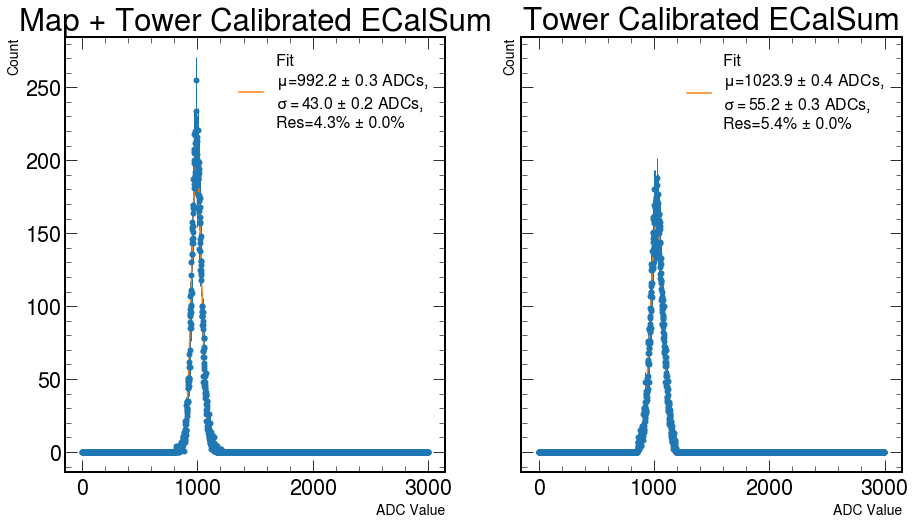

In [1030]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8), sharey = True)

x_pos = 0
y_pos = 0

width = 5000


posmask = (calix_reco > (x_pos - width)) & (calix_reco < (x_pos + width)) & (caliy_reco > (y_pos - width)) & (caliy_reco < (y_pos + width))

#posmask1 = (calix_reco > (x_pos - width)) & (calix_reco < (x_pos + width)) & (caliy_reco > (y_pos - width)) & (caliy_reco < (y_pos + width))
#posmask2 = (calix_reco > (-x_pos - width)) & (calix_reco < (-x_pos + width)) & (caliy_reco > (y_pos - width)) & (caliy_reco < (y_pos + width))
#posmask3 = (calix_reco > (x_pos - width)) & (calix_reco < (x_pos + width)) & (caliy_reco > (-y_pos - width)) & (caliy_reco < (-y_pos + width))
#posmask4 = (calix_reco > (-x_pos - width)) & (calix_reco < (-x_pos + width)) & (caliy_reco > (-y_pos - width)) & (caliy_reco < (-y_pos + width))
#posmask = posmask1 | posmask2 | posmask3 | posmask4

h, bins = np.histogram(map_caliEvtSum[posmask], bins=bins, range=(lowRange,highRange))
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(h)
axs[0].errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue',
                      capsize=0, elinewidth=1, markeredgewidth=0)

mask = (h > 0) & (bin_centers > lowFit) & (bin_centers < highFit)

initial_params = [max(h[mask]),np.mean(map_caliEvtSum[map_caliEvtSum > lowFit]),np.std(map_caliEvtSum[map_caliEvtSum > lowFit])]

m = Minuit(LeastSquares(bin_centers[mask], h[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
m.limits["sigma"] = (0, None)
m.migrad()
fitted_params = m.values
errors = m.errors
A_fit = fitted_params['A']
mu_fit = fitted_params['mu']
sigma_fit = fitted_params['sigma']
A_err = errors['A']
mu_err = errors['mu']
sigma_err = errors['sigma']
x = np.linspace(lowFit, highFit, 2000)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
res = np.sqrt((100*res)**2 - 1.8**2)
# Step 1: Calculate r and its error
r = sigma_fit / mu_fit
delta_r = r * np.sqrt((sigma_err / sigma_fit)**2 + (mu_err / mu_fit)**2)
# Step 2: Calculate s and its error
s = 100 * r
delta_s = 100 * delta_r
# Step 3: Calculate res and its error
res = np.sqrt(s**2 - 1.8**2)
delta_res = (s / np.sqrt(s**2 - 1.8**2)) * delta_s

x = np.linspace(lowFit, highFit, 1500)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
res = 100 * sigma_fit/mu_fit

axs[0].plot(x, y_fit, 'tab:orange', label='Fit \n$\mu$=%2.1f ± %2.1f ADCs, \n$\sigma=$%2.1f ± %2.1f ADCs, \nRes=%2.1f%% ± %2.1f%%'%(mu_fit, mu_err, sigma_fit, sigma_err, res, delta_res))
axs[0].legend(loc='upper right', fontsize=16)   

print("Mean: " + str(mu_fit))
print("Mean Error: " + str(mu_err))
print("Resolution: " + str(res))
print("Resolution Error: " + str(delta_res))

caliElectronMean = mu_fit
caliElectronErr = mu_err
caliElectronRes = res
caliElectronResErr = delta_res

axs[0].set_title("Map + Tower Calibrated ECalSum")
axs[0].set_xlabel("ADC Value", fontsize = 14)
axs[0].set_ylabel("Count", fontsize = 14)


plt.title("ECalSumElectron")
plt.xlabel("ADC Value")
plt.ylabel("Count")

h, bins = np.histogram(ECalSumElectron[posmask], bins=bins, range=(lowRange,highRange))
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(h)
axs[1].errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue',
                      capsize=0, elinewidth=1, markeredgewidth=0)


mask = (h > 0) & (bin_centers > lowFit) & (bin_centers < highFit)

initial_params = [max(h[mask]),np.mean(ECalSumElectron[ECalSumElectron > lowFit]),np.std(ECalSumElectron[ECalSumElectron > lowFit])]

m = Minuit(LeastSquares(bin_centers[mask], h[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
m.limits["sigma"] = (0, None)
m.migrad()
fitted_params = m.values
errors = m.errors
A_fit = fitted_params['A']
mu_fit = fitted_params['mu']
sigma_fit = fitted_params['sigma']
A_err = errors['A']
mu_err = errors['mu']
sigma_err = errors['sigma']
x = np.linspace(lowFit, highFit, 2000)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
res = np.sqrt((100*res)**2 - 1.8**2)
# Step 1: Calculate r and its error
r = sigma_fit / mu_fit
delta_r = r * np.sqrt((sigma_err / sigma_fit)**2 + (mu_err / mu_fit)**2)
# Step 2: Calculate s and its error
s = 100 * r
delta_s = 100 * delta_r
# Step 3: Calculate res and its error
res = np.sqrt(s**2 - 1.8**2)
delta_res = (s / np.sqrt(s**2 - 1.8**2)) * delta_s

x = np.linspace(lowFit, highFit, 1500)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
res = 100 * sigma_fit/mu_fit

axs[1].plot(x, y_fit, 'tab:orange', label='Fit \n$\mu$=%2.1f ± %2.1f ADCs, \n$\sigma=$%2.1f ± %2.1f ADCs, \nRes=%2.1f%% ± %2.1f%%'%(mu_fit, mu_err, sigma_fit, sigma_err, res, delta_res))
axs[1].legend(loc='upper right', fontsize=16)   

axs[1].set_title("Tower Calibrated ECalSum")
axs[1].set_xlabel("ADC Value", fontsize = 14)
axs[1].set_ylabel("Count", fontsize = 14)

In [1031]:
ECalYield[2].append(caliElectronMean)
ECalYieldErr[2].append(caliElectronErr)
ECalRes[2].append(caliElectronRes)
ECalResErr[2].append(caliElectronResErr)
print(ECalYield)
print(ECalRes)

[[227.87843406224073, 413.78679593244544, 585.7477048481936, 740.5405742663262, 884.6050321790431], [230.05136149409552, 419.0975602586781, 600.8584310894673, 764.7285278709321, 916.3636482211518], [234.13009631008393, 441.1196956034997, 637.075264693578, 819.779312780135, 992.1518952360819]]
[[9.900328053671693, 7.794911930597398, 6.906252744496981, 6.41866149121874, 6.0661377361359365], [8.42567340838005, 7.238768581237474, 5.8142125888392675, 5.208079196915626, 4.840270847120447], [8.595937924474061, 6.357580958914087, 5.320440010167886, 4.714466608047221, 4.331843098314701]]


In [931]:
BeamE = [2.2077120822622107, 4.207712082262211, 6.207712082262211, 8.20771208226221, 10.20771208226221]

# Do not progress untill all energies are run

/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


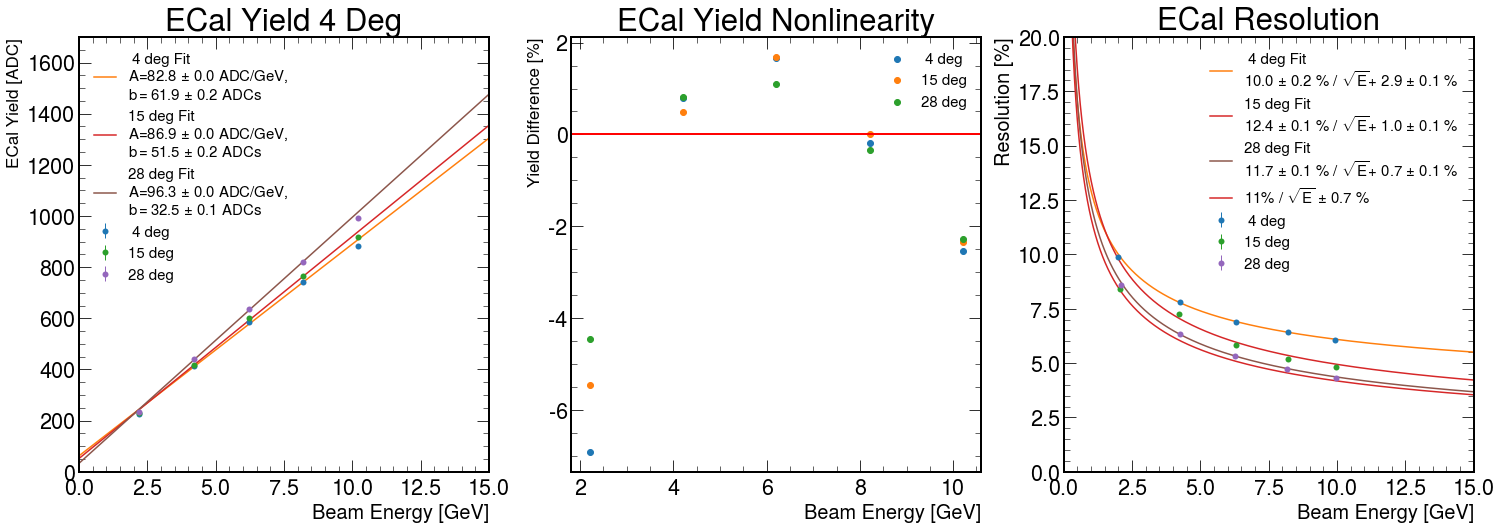

In [1049]:
fig, axs = plt.subplots(1, 3, figsize=(25, 8))

for i,d in enumerate(deg):

    axs[0].errorbar(BeamE, ECalYield[i], yerr=ECalYieldErr[i], fmt='o',
                      capsize=0, elinewidth=1, markeredgewidth=0, label='%2.0f deg'%(d))
    axs[0].set_xlim(0,15)
    axs[0].set_ylim(0,1700)

    axs[0].set_xlabel("Beam Energy [GeV]", size=20)
    axs[0].set_ylabel("ECal Yield [ADC]", size=17)

    initial_params = [0,0]

    m = Minuit(LeastSquares(BeamE, ECalYield[i], ECalYieldErr[i], lin), A=initial_params[0], b=initial_params[1])
    m.migrad()
    fitted_params = m.values
    errors = m.errors
    yA_fit = fitted_params['A']
    yA_err = errors['A']
    yb_fit = fitted_params['b']
    yb_err = errors['b']
    x = np.linspace(0,15,1500)
    y_fit = lin(x, yA_fit, yb_fit)
    axs[0].plot(x, y_fit, label='%2.0f deg Fit \n$A$=%2.1f ± %2.1f ADC/GeV, \n$b=$%2.1f ± %2.1f ADCs'%(d, yA_fit, yA_err, yb_fit, yb_err))

    axs[0].legend(fontsize=15)
    axs[0].set_title("ECal Yield 4 Deg")

    def correctedE(x):
        return (x - yb_fit)/yA_fit

    correctedADC = lin(np.array(BeamE), yA_fit, yb_fit)
    Ediff = 100 * (ECalYield[i] - correctedADC) / correctedADC

    axs[1].scatter(BeamE, Ediff, label='%2.0f deg'%(d))
    axs[1].legend(fontsize=15)
    axs[1].axhline(y=np.mean(0), color='red')
    axs[1].set_title("ECal Yield Nonlinearity")
    axs[1].set_xlabel("Beam Energy [GeV]", size=20)
    axs[1].set_ylabel("Yield Difference [%]", size=17)
    
    axs[2].set_xlim(0,15)
    axs[2].set_ylim(0,20)

    axs[2].set_xlabel("Beam Energy [GeV]", size=20)
    axs[2].set_ylabel("Resolution [%]", size=20)
    
    axs[2].errorbar(correctedE(np.array(ECalYield[i])), ECalRes[i], yerr=ECalResErr[i], fmt='o',
                      capsize=0, elinewidth=1, markeredgewidth=0, label='%2.0f deg'%(d))

    initial_params = [0,0]

    m = Minuit(LeastSquares(correctedE(np.array(ECalYield[i])), ECalRes[i], ECalResErr[i], resolution), A=initial_params[0], b=initial_params[1])
    m.migrad()
    fitted_params = m.values
    errors = m.errors
    A_fit = fitted_params['A']
    A_err = errors['A']
    b_fit = fitted_params['b']
    b_err = errors['b']
    x = np.linspace(0,15,1500)
    y_fit = resolution(x, A_fit, b_fit)
    axs[2].plot(x, y_fit, label='%2.0f deg Fit\n'r'%2.1f ± %2.1f %% / $\sqrt{E}$' '$+$ %2.1f ± %2.1f %%'%(d, A_fit,A_err,b_fit,b_err))

    axs[2].set_title("ECal Resolution")
    
y_old = resolution(x, 11, 0.7)    
x = np.linspace(0,15,1500) 
axs[2].plot(x, y_old, 'tab:red', label='11% / ' r'$\sqrt{E}$'' ± 0.7 %')
axs[2].legend(fontsize = 15, loc='upper right')

/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


Text(0.5, 1.0, 'ECal Resolution 4 Deg')

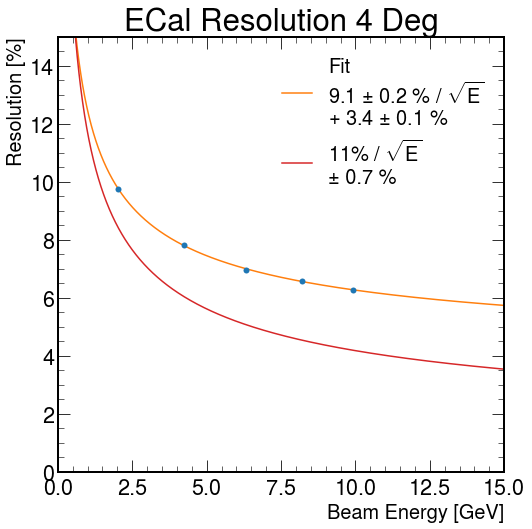

In [807]:
plt.figure(figsize=(8, 8))

plt.errorbar(correctedE(np.array(ECalYield[0])), ECalRes[0], yerr=ECalResErr[0], fmt='o', ecolor='tab:blue', color='tab:blue',
                      capsize=0, elinewidth=1, markeredgewidth=0)

plt.xlim(0,15)
plt.ylim(0,15)

plt.xlabel("Beam Energy [GeV]", size=20)
plt.ylabel("Resolution [%]", size=20)

initial_params = [0,0]

m = Minuit(LeastSquares(correctedE(np.array(ECalYield[0])), ECalRes[0], ECalResErr[0], resolution), A=initial_params[0], b=initial_params[1])
m.migrad()
fitted_params = m.values
errors = m.errors
A_fit = fitted_params['A']
A_err = errors['A']
b_fit = fitted_params['b']
b_err = errors['b']
x = np.linspace(0,15,1500)
y_fit = resolution(x, A_fit, b_fit)
plt.plot(x, y_fit, 'tab:orange', label='Fit\n'r'%2.1f ± %2.1f %% / $\sqrt{E}$' '\n$+$ %2.1f ± %2.1f %%'%(A_fit,A_err,b_fit,b_err))

y_old = resolution(x, 11, 0.7)
plt.plot(x, y_old, 'tab:red', label='11% / ' r'$\sqrt{E}$''\n± 0.7 %')

plt.legend(fontsize = 20)

plt.title("ECal Resolution 4 Deg")